In [43]:
__author__ = ['xiaodan']

## Contents

#### 0. Data Wrangling
* 0.1 functions for text preprocessing
* 0.2 functions for models

#### 1. Machine Learning Models before Relabelling  (baseline)
* 1.1 Logistic Regression before Relabelling
* 1.2 Random Forest before Relabelling

#### 2. Handling Imbalance Data 
* 2.1 balanced ensemble method (balanced random forest)
* 2.2 weighted ensemble method (weighted random forest)

#### 3. Machine Learning Models after Relabelling
* 3.1 Logistic Regression after Relabelling
* 3.2 Random Forest after Relabelling

#### 4. Grid Search
* 4.1 pipeline for grid search for text preprocessing (bow & tfidf) and machine learning models

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import string

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')

## 0. Data Wrangling

### 0.1 functions for text preprocessing

In [3]:
def get_data(path):
    '''
    get data
    :return: data and its labels
    '''
    data = pd.read_csv(path,index_col=0)
    return data


def split_data(corpus, labels, test_data_proportion=0.3):
    '''
    :param corpus: data
    :param labels: labels
    :param test_data_proportion:proportion 
    '''
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion, 
                                                        random_state=42)
    return train_X, test_X, train_Y, test_Y

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

def remove_stopwords(text):
    stop = list(set(stopwords.words('english')))
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def text_preprocessing(corpus):
    normalized_corpus = []
    for text in corpus:
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
    return normalized_corpus


def bow_model(corpus, ngram_range=(1, 1),min_df=0.1,max_df=0.9,max_features=5000):
    vectorizer = CountVectorizer(min_df=min_df,
                                 max_df=max_df,
                                 stop_words='english',
                                 ngram_range=ngram_range,
                                 max_features = max_features)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix


def tfidf_model(corpus, ngram_range=(1, 1),min_df=0.1,max_df=0.9,max_features=5000):
    vectorizer = TfidfVectorizer(min_df=min_df,
                                 max_df=max_df,
                                 stop_words='english',
                                 ngram_range=ngram_range,
                                 max_features = max_features)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

### 0.2 functions for models

In [4]:
def train_predict_evaluate_model(classifier,
                                 train_features, train_labels,
                                 test_features, test_labels):
          
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    # evaluate model prediction performance
    print(get_metrics(true_labels=test_labels,predicted_labels=predictions))
    return classifier
    
def get_metrics(true_labels, predicted_labels):
    return metrics.classification_report(true_labels,predicted_labels)

### 0.3 get data and the result for the random forest model without dealing with imbalance data

In [6]:
data = get_data('./data/data.csv')

In [5]:
# replace all '-1' class with '0'
data2 = data.copy()
data2['tagged'].replace({-1:0},inplace=True)

In [6]:
data2.head()

,support,text,volume_no,issue_no,page_range,person_id,full_name,party,chamber,title,tagged
0,1,"Mr. GRAYSON . Mr. Speaker, these statements an...",159,42,E357-E358,29284,Alan-nan-Grayson,D,H,Catching Up to 1968 Act of 2013,1
1,1,"Ms. GABBARD . Mr. Speaker, I rise today in str...",159,42,E362,46246,Tulsi-nan-Gabbard,D,H,Helping Heroes Fly Act,1
2,1,"Mr. FALEOMAVAEGA . Mr. Speaker, I want to shar...",159,42,E363-E364,19,Eni-F.H.-Faleomavaega,D,H,Non-Disparagement of Native American Persons o...,1
3,-1,"Mr. COHEN . Mr. Speaker, I rise today to share...",159,39,H1559,1762,Steve-nan-Cohen,D,H,Northern Route Approval Act,1
4,1,"Ms. JACKSON LEE . Mr. Speaker, in a few weeks,...",159,42,H1725,475,Sheila-nan-Jackson Lee,D,H,Child Gun Safety and Gun Access Prevention Act,1


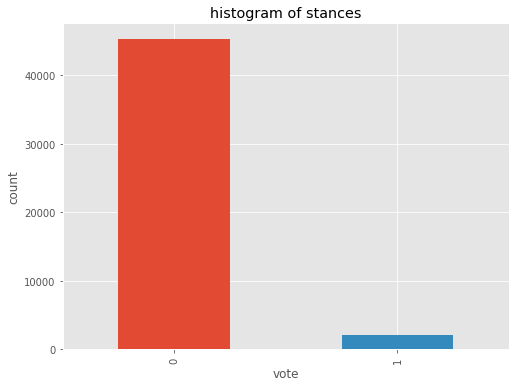

In [7]:
#data.info()
# check if the data is imbalanced
fig = plt.figure(figsize=(8,6))
data2.groupby('tagged').text.count().plot.bar(ylim=0)
plt.title('histogram of stances')
plt.ylabel('count')
plt.xlabel('vote')
plt.show()

## 1. Machine Learning Models before Relabelling  (baseline)

### 1.1 Logistic Regression model before handling imbalance data (not recommended)

In [8]:
X,y = data2['text'].values, data2['tagged'].values
train_corpus, test_corpus, train_labels, test_labels = split_data(X,y,test_data_proportion=0.3)
 # normalization
norm_train_corpus = text_preprocessing(train_corpus)
norm_test_corpus = text_preprocessing(test_corpus)

# bag of words
#bow_vectorizer, bow_train_features = bow_model(norm_train_corpus)
#bow_test_features = bow_vectorizer.transform(norm_test_corpus)

# tfidf 
tfidf_vectorizer, tfidf_train_features = tfidf_model(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
# logistic regression classifier using tfidf
print("logistic regression classifier using tfidf")
lr_tfidf_predictions = train_predict_evaluate_model(classifier=lr,
                                                    train_features=tfidf_train_features,
                                                    train_labels=train_labels,
                                                    test_features=tfidf_test_features,
                                                    test_labels=test_labels)

logistic regression classifier using tfidf
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     13589
           1       0.12      0.77      0.21       640

   micro avg       0.74      0.74      0.74     14229
   macro avg       0.55      0.76      0.53     14229
weighted avg       0.95      0.74      0.82     14229



### 1.2 Random Forest before  Handling Imbalance Data (not recommended)

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs=-1)
# random forest classifier using tfidf
print("random forest classifier using tfidf")
rfc_tfidf_predictions = train_predict_evaluate_model(classifier=rfc,
                                                     train_features=tfidf_train_features,
                                                     train_labels=train_labels,
                                                     test_features=tfidf_test_features,
                                                     test_labels=test_labels)

random forest classifier using tfidf
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     13589
           1       0.19      0.15      0.16       640

   micro avg       0.93      0.93      0.93     14229
   macro avg       0.57      0.56      0.56     14229
weighted avg       0.93      0.93      0.93     14229



**finding:**  the difference between the f1 score for each category is so large

## 2. Handling Imbalance Data 

### 2.1 balanced ensemble method (balanced random forest) (the performance is not good)

* draw a bootstrap sample from the minority class and draw a bootstrap sample from the majority class with the same size of the minority sample

* induce a classification tree to maximize size without pruning. the tree is induced with CART algorithm with the modification of only searching through a set of m randomly selected variables instead of searching through all variables to find the optimal split

* repeat 2 steps above, aggregate the predictions of the emsemble above and get the final prediction

* reference: https://imbalanced-learn.org/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

In [29]:
# ! pip install -U imbalanced-learn

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100)

In [14]:
# balanced random forest classifier using tfidf
print("balanced random forest classifier using tfidf")
rfc_tfidf_predictions = train_predict_evaluate_model(classifier=brf,
                                                     train_features=tfidf_train_features,
                                                     train_labels=train_labels,
                                                     test_features=tfidf_test_features,
                                                     test_labels=test_labels)

balanced random forest classifier using tfidf
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     13589
           1       0.12      0.87      0.22       640

   micro avg       0.72      0.72      0.72     14229
   macro avg       0.56      0.79      0.52     14229
weighted avg       0.95      0.72      0.80     14229



**finding:** metrics are all improved significantly with balanced random forest

### 2.2 weighted ensemble method (weighted random forest) ( the performance is not good)

* place a penalty on misclassifying the minority class. we assign a weight to each class, for the minority class we give a larger weight (i.e. higher classification cost)

* The class weights are incorporated into the RF algorithm in two places. In the tree induction procedure, class weights are used to weight the Gini criterion for finding splits. In the terminal nodes of each tree, class weights are again taken into consideration. The class prediction of each terminal node is determined by “weighted majority vote”; i.e., the weighted vote of a class is the weight for that class times the number of cases for that class at the terminal node. 

* The final class prediction for RF is then determined by aggregatting the weighted vote from each individual tree, where the weights are average weights in the terminal nodes. Class weights are an essential tuning parameter to achieve desired performance. The out-of-bag estimate of the accuracy from RF can be used to select weights. This method, Weighted Random Forest (WRF), is incorporated in the present version of the software.

In [15]:
# weighted balanced random forest classifier using tfidf
wrf_brf = BalancedRandomForestClassifier(n_estimators=100,class_weight='balanced')
print("weighted balanced random forest classifier using tfidf")
rfc_tfidf_predictions = train_predict_evaluate_model(classifier=wrf_brf,
                                                     train_features=tfidf_train_features,
                                                     train_labels=train_labels,
                                                     test_features=tfidf_test_features,
                                                     test_labels=test_labels)

weighted balanced random forest classifier using tfidf
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     13589
           1       0.10      0.89      0.19       640

   micro avg       0.65      0.65      0.65     14229
   macro avg       0.55      0.76      0.48     14229
weighted avg       0.95      0.65      0.75     14229



**findings:** the performance of the balanced ensemble method is better than the weighted method

## 3. Machine Learning models after Relabelling (Solution!)

In [64]:
import data_preprocessing

In [69]:
# split data and call text preprocessing method for relabelling
data3 = data.copy()
#data3['tagged'].replace({-1:0},inplace=True)

In [70]:
train_corpus, test_corpus, train_labels, test_labels = data_preprocessing.split(data3)

In [72]:
# tfidf 
tfidf_vectorizer, tfidf_train_features_relabel = tfidf_model(train_corpus)
tfidf_test_features_relabel = tfidf_vectorizer.transform(test_corpus)

In [73]:
Counter(train_labels)

Counter({-1: 18218, 1: 14981})

### 3.1 Logistic Regression model after handling imbalance data

In [79]:
# logistic regression classifier using tfidf
lr = LogisticRegression(class_weight='balanced',C=0.01)
# logistic regression classifier using tfidf
print("logistic regression classifier using tfidf after relabelling")
lr_tfidf_predictions = train_predict_evaluate_model(classifier=lr,
                                                    train_features=tfidf_train_features_relabel,
                                                    train_labels=train_labels,
                                                    test_features=tfidf_test_features_relabel,
                                                    test_labels=test_labels)

logistic regression classifier using tfidf after relabelling
              precision    recall  f1-score   support

          -1       0.87      0.79      0.83      7925
           1       0.76      0.85      0.80      6304

   micro avg       0.82      0.82      0.82     14229
   macro avg       0.81      0.82      0.81     14229
weighted avg       0.82      0.82      0.82     14229



In [80]:
# get feature names and their corresponding coefficients from lr
feature_dic = {}
features = tfidf_vectorizer.get_feature_names()
imp = lr_tfidf_predictions.coef_[0]
for i in range(len(features)):
    feature_dic[features[i]] = imp[i]


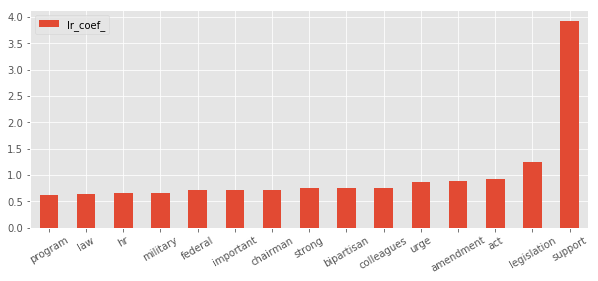

In [111]:
# the top 15 features that have the relatively higher weights for bills with stances
importances = pd.DataFrame.from_dict(feature_dic, orient='index').rename(columns={0: 'lr_coef_'})
importances.sort_values(by='lr_coef_')[-15:].plot(figsize=(10,4),kind='bar',rot=30)

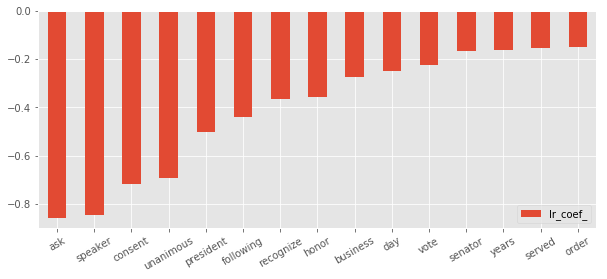

In [110]:
# the top 15 features that have the relatively higher weights for bills with no stances
importances.sort_values(by='lr_coef_')[:15].plot(figsize=(10,4),kind='bar',rot=30)

### 3.2 Random Forest model after handling imbalance data

In [84]:
print("random forest classifier using tfidf after relabelling")
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs=-1)
rfc_tfidf_predictions = train_predict_evaluate_model(classifier=rfc,
                                                     train_features=tfidf_train_features_relabel,
                                                     train_labels=train_labels,
                                                     test_features=tfidf_test_features_relabel,
                                                     test_labels=test_labels)

random forest classifier using tfidf after relabelling
              precision    recall  f1-score   support

          -1       0.89      0.93      0.91      7925
           1       0.91      0.86      0.88      6304

   micro avg       0.90      0.90      0.90     14229
   macro avg       0.90      0.89      0.90     14229
weighted avg       0.90      0.90      0.90     14229



In [112]:
def get_rf_feature_importance(vectorizer,model):
    '''
    input: dataframe
    output: feature importance dataframe, feature importance plot
    '''
    # a dict to hold feature_name: feature_importance
    feats = {} 
    for feature, importance in zip(vectorizer.get_feature_names(), model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance')[-20:].plot(figsize=(10,4),kind='bar',rot=30)
    plt.savefig('rf_feature_importance.png')
    return importances

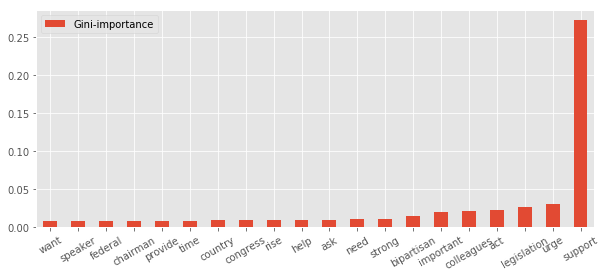

In [113]:
# feature importace
importance = get_rf_feature_importance(tfidf_vectorizer,rfc_tfidf_predictions)

## 3. Grid Search

### 3.1 grid search for text preprocessing (bow & tfidf) and models

In [29]:
from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#print(__doc__)
# Display progress logs on stdout
#logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')
# Define a pipeline combining a text feature extractor with a simple classifier
rfc = RandomForestClassifier()
brf = BalancedRandomForestClassifier()
pipeline = Pipeline([('tfidf', TfidfVectorizer()),('clf', brf)])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {'tfidf__max_df': (0.7,0.8, 0.9),
              'tfidf__min_df': (0.1, 0.2,0.3),
              #'tfidf__max_features': (5000, 10000),
              'tfidf__ngram_range': ((1,1),(1, 2)),  # unigrams or bigrams
              'clf__n_estimators': (100,150),
              'clf__max_depth': (10,30,50),
              'clf__class_weight': (None, 'balanced')}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    # find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(norm_train_corpus, train_labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__class_weight': (None, 'balanced'),
 'tfidf__max_df': (0.8, 0.9),
 'tfidf__min_df': (0.1, 0.2),
 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.6min finished


done in 219.328s

Best score: 0.858
Best parameters set:
	clf__class_weight: None
	tfidf__max_df: 0.9
	tfidf__min_df: 0.1
	tfidf__ngram_range: (1, 1)
